In [1]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pdb

from utils import load_data, accuracy, normalize_adj
from models import GAT, SpGAT


In [2]:
# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...


In [3]:
# model = SpGAT(nfeat=1433, 
#                 nhid=8, 
#                 nclass=7, 
#                 dropout=0.6, 
#                 nheads=8, 
#                 alpha=0.2)

model = torch.load('model.pth')

model.cuda()
features = features.cuda()
adj = adj.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()


In [4]:
model

GAT(
  (attention_0): GraphAttentionLayer (1433 -> 8)
  (attention_1): GraphAttentionLayer (1433 -> 8)
  (attention_2): GraphAttentionLayer (1433 -> 8)
  (attention_3): GraphAttentionLayer (1433 -> 8)
  (attention_4): GraphAttentionLayer (1433 -> 8)
  (attention_5): GraphAttentionLayer (1433 -> 8)
  (attention_6): GraphAttentionLayer (1433 -> 8)
  (attention_7): GraphAttentionLayer (1433 -> 8)
  (out_att): GraphAttentionLayer (64 -> 7)
)

In [5]:
model.eval()
output, _ = model(features, adj)
loss_test = F.nll_loss(output[idx_test], labels[idx_test])
acc_test = accuracy(output[idx_test], labels[idx_test])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.data[0]),
      "accuracy= {:.4f}".format(acc_test.data[0]))

Test set results: loss= 0.6064 accuracy= 0.8450


/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


In [6]:
probs = torch.exp(output).cpu().detach().numpy()
labels = labels.cpu().detach().numpy()
bins = np.arange(0, 1.1, 0.05)
inds = np.digitize(probs, bins) - 1

probs, inds, labels

(array([[9.70403125e-05, 1.35137234e-04, 1.31750348e-04, ...,
         8.13976294e-05, 9.99364078e-01, 9.09266746e-05],
        [6.39558807e-02, 2.06505470e-02, 2.97233909e-02, ...,
         3.21251974e-02, 2.40277722e-02, 2.19605267e-02],
        [1.31304993e-03, 6.75135816e-04, 1.22820167e-03, ...,
         8.80766485e-04, 9.59069177e-04, 9.93753850e-01],
        ...,
        [1.76413544e-02, 1.38439592e-02, 8.63996863e-01, ...,
         1.80933159e-02, 3.20498198e-02, 1.44489706e-02],
        [1.28949843e-02, 9.16647818e-03, 1.42125664e-02, ...,
         8.87108326e-01, 1.37146264e-02, 2.89653055e-02],
        [6.87805889e-03, 1.00686215e-02, 1.44255431e-02, ...,
         6.31003967e-03, 9.43994105e-01, 5.21368766e-03]], dtype=float32),
 array([[ 0,  0,  0, ...,  0, 19,  0],
        [ 1,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0, 19],
        ...,
        [ 0,  0, 17, ...,  0,  0,  0],
        [ 0,  0,  0, ..., 17,  0,  0],
        [ 0,  0,  0, ...,  0, 18,  0]]),
 

0.025 0.006143584342636475
0.07500000000000001 0.03431909456005842
0.125 0.08227848101265822
0.17500000000000002 0.13655462184873948
0.225 0.19786096256684493
0.275 0.36947791164658633
0.32500000000000007 0.4661016949152542
0.375 0.5050505050505051
0.42500000000000004 0.5988023952095808
0.475 0.6944444444444444
0.525 0.7480916030534351
0.5750000000000001 0.78125
0.625 0.8048780487804879
0.675 0.8157894736842105
0.7250000000000001 0.8709677419354839
0.775 0.9069767441860465
0.8250000000000001 0.8757396449704142
0.875 0.9216589861751152
0.925 0.9326241134751773
0.9750000000000001 0.9755700325732899


/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


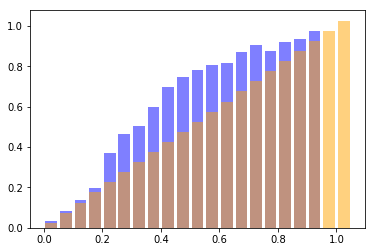

ECE 0.036323591474994726


In [34]:
def ECE(inds, labels, bins):
    ## Produce Plot
    labels_onehot = torch.zeros(7, len(labels)).scatter_(0,torch.LongTensor([labels]),1).numpy().T
    bin_avgs = (bins[:-1] + bins[1:]) / 2

    ece = 0
    true_probs = []
    for idx, b in enumerate(bins):
        num = np.sum(inds == idx)
        # print(labels_onehot, inds == idx, 'value', labels_onehot[inds == idx])
        correct = np.sum(labels_onehot[inds == idx])
        true_probs.append(correct/num)
        if num > 0:
            print(bin_avgs[idx], correct/num)
            ece += num / (7 * len(labels)) * np.abs(bin_avgs[idx] - correct/num)     
            # print(num / (7 * len(labels)) * np.abs(bin_avgs[idx] - correct/num))

    import matplotlib.pyplot as plt
    plt.bar(bin_avgs, true_probs[1:], width=bins[1]-bins[0]-0.01, color='blue', alpha=0.5) #true
    plt.bar(bin_avgs, bin_avgs, width=bins[1]-bins[0]-0.01, color='orange', alpha=0.5) #ideal
    plt.show()

    print("ECE", ece)
    
ECE(inds, labels, bins) #whole set

/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


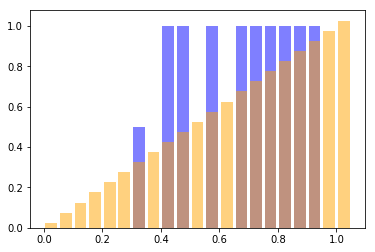

ECE 0.03647959183673469


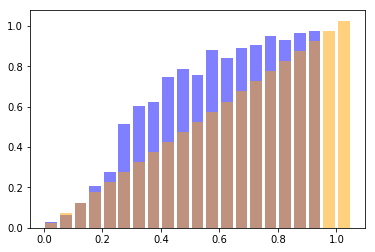

ECE 0.04196428571428572


(None, None)

In [33]:
ECE(inds[idx_train,:], labels[idx_train], bins), ECE(inds[idx_test,:], labels[idx_test], bins)